# First Prototype for generating a more sophisticated web app

import libs and load data

In [1]:
# local utilities
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities.BTTools import filter_for
from utilities.BTTools import groupSpeechesByDiscussionTitle

# other stuff needed
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import tqdm

import json

with open('../../data/speeches_20.jsonl', 'r', encoding='utf8') as fp:
    data = list(fp)
speeches_original = []
for line in data:
    speeches_original.append(json.loads(line))
    
speeches = speeches_original.copy()    

## 1. Topic Model at the level of TOPs


### 1.1 Create Corpus

#### restructure data per TOP

In [3]:
groupedby_discussion = groupSpeechesByDiscussionTitle(speeches)
len(groupedby_discussion)

208

#### build corpus for scikit learn methods

In [4]:
corpus = []
for top in groupedby_discussion.values():
    #print(grouped[top])
    aggregate= []
    for ele in top:
        aggregate.append(ele['text'])
    corpus.append(' '.join(aggregate))

len(corpus)    


208

#### optional: preprocessing with spacy

In [5]:

import spacy
nlp = spacy.load('de') #load spacy model


In [6]:

def corpus_by_POS(corpus,consider):
    corpus_by = []  
    for row in tqdm.tqdm(corpus):
        doc = nlp(row)
        new_row = []
        for token in doc:
            if token.pos_ in consider:
                new_row.append(token.lemma_)
        corpus_by.append(' '.join(new_row))
    return corpus_by 


In [ ]:
consider = ['NOUN']
        
corpus_nouns = corpus_by_POS(corpus,consider)        
len(corpus_nouns)

In [ ]:
corpus = corpus_nouns
corpus[0]

### 1.2 Topic Model

#### vectorize data

In [7]:
vectorizer_tfidf = TfidfVectorizer(max_df=0.8, min_df=0.01,lowercase = False)
tf_idf_matrix  = vectorizer_tfidf.fit_transform(corpus)
feature_names = vectorizer_tfidf.get_feature_names()
vectorizer_tf = TfidfVectorizer(vocabulary=feature_names,use_idf=False, norm="l1")
#vectorizer_counts = CountVectorizer(vocabulary=feature_names)
tf_matrix = vectorizer_tf.fit_transform(corpus)

tf_idf_matrix

<208x19567 sparse matrix of type '<class 'numpy.float64'>'
	with 300671 stored elements in Compressed Sparse Row format>

#### compute topic model

In [24]:
# Use NMF to look for 15 topics
n_topics = 10
model = NMF(n_components=n_topics)
model.fit(tf_idf_matrix)
#model.fit(tf_matrix)

# Print the top 10 words
n_words = 10
n_words_features = 100

topic_list = []
topic_list_ext = []
topic_words = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 
    topic_list_ext.append(top_features)
    
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words_features:]][::-1]
    topic_words.append(top_n)

    print(f"Topic {topic_idx}: {top_features}")
    
topic2word = model.components_   
#topic_words

Topic 0: Energien Gas erneuerbaren EEG Ausbau Strom Umlage Energieversorgung Energiewende LNG
Topic 1: Ukraine Russland Krieg NATO Putin Europa Waffen Bundeskanzler russischen Sanktionen
Topic 2: Impfpflicht Impfung Pandemie impfen Omikron Pflege Impfen geimpft Variante Impfungen
Topic 3: Euro Milliarden Haushalt Sondervermögen Nachtragshaushalt Investitionen Pandemie Wirtschaft Unternehmen Bundeswehr
Topic 4: Mali Mandat Soldaten Soldatinnen Bundeswehr Mission Südsudan Libyen Sea MINUSMA
Topic 5: Wohnungen Bauen Wohnen Mieter Vorkaufsrecht Mieterinnen Wohnraum CO2 Wohnungsbau Kommunen
Topic 6: Landwirtschaft Landwirte Hunger Ernährung Bauern Lebensmittel Millionen Flächen Welt Ukraine
Topic 7: Inflation Euro Einkommen Entlastung Antrag entlasten Progression Preise Rentner Energiepreispauschale
Topic 8: Antrag Demokratie Opfer Sicherheitsbehörden Hanau Rechtsextremismus Frauen 219a Antidiskriminierungsstelle Rechtsstaat
Topic 9: Kinder Kommunen Ganztagsbetreuung Frauen Schulen Bund Bil

In [15]:
#topic_words

### Word Clouds for Topic

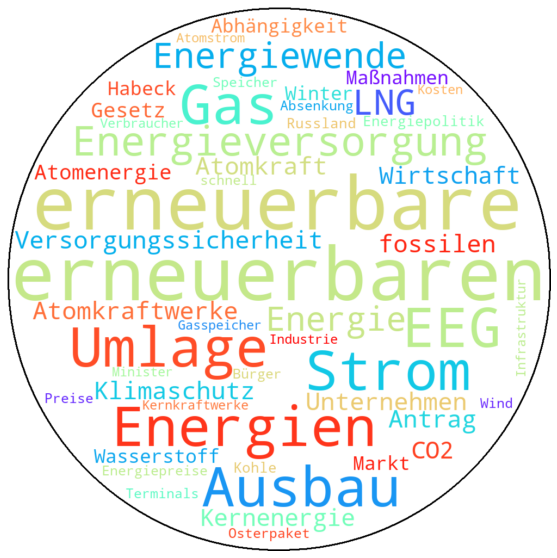

In [26]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud

mask = np.array(Image.open("circle.png"))

# parameters:

wordcloud = WordCloud(background_color='white', max_words=50, mask=mask, contour_color='#000000', contour_width=3, colormap='rainbow').generate(" ".join(topic_words[0]))

# create image as circle

fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# presentate:

plt.show()


# generate PNG for all topics
for tx,topic in enumerate(topic_words):
    wordcloud = WordCloud(background_color='white', max_words=50, mask=mask, contour_color='#000000', contour_width=3, colormap='rainbow').generate(" ".join(topic_words[tx]))

    wordcloud.to_file(f"wordclouds/wordcloud_{tx}.png")


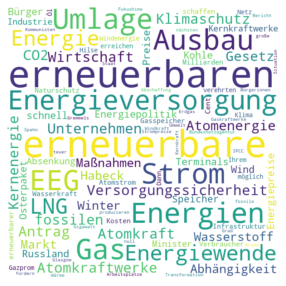

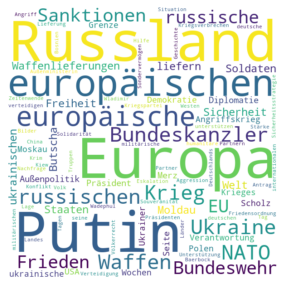

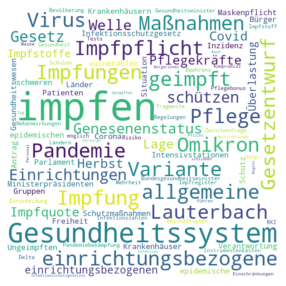

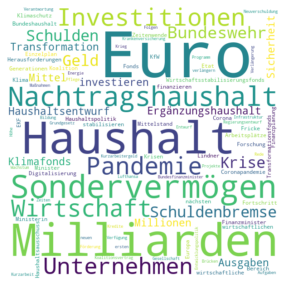

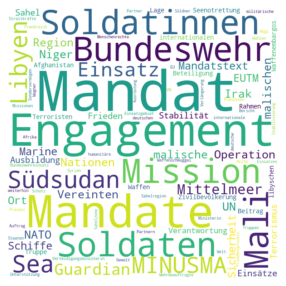

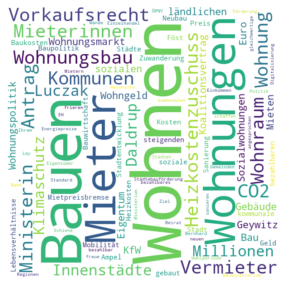

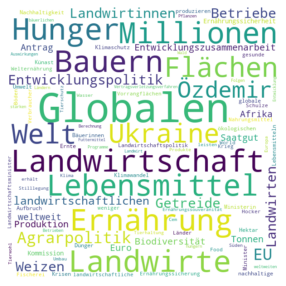

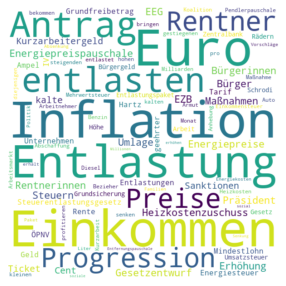

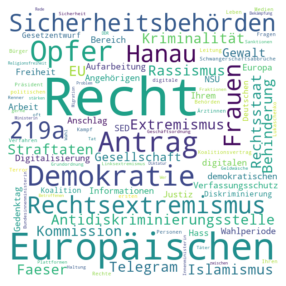

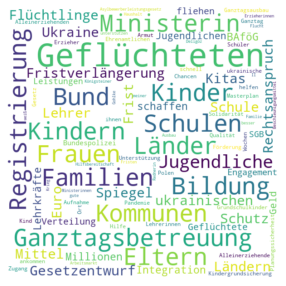

In [27]:


# parameters:

#wordcloud = WordCloud(width=600, height=600, mode = "RGBA", background_color='rgba(255, 255, 255, 0)', max_words=100,  contour_color='#000000', contour_width=0, colormap='rainbow').generate_from_frequencies(topic_words)
for tx,topic in enumerate(topic_words):
    wordcloud = WordCloud(width = 600, height = 600,background_color='rgba(255, 255, 255, 0)').generate(" ".join(topic_words[tx]))
    fig = plt.figure(figsize=(5,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

# presentate:

    plt.show()





#### document topic probabilities

In [ ]:
print(tf_matrix.shape)
print(topic2word.shape)
doc2topic = (tf_matrix * topic2word.T)
print(doc2topic.shape)

In [ ]:
topic2word.T[0]

#### find max contributions for words and docs

In [ ]:
feature_topic_num = []
feature_topic_name = []
for wx,word in enumerate(feature_names):
    if topic2word.T[wx].max() > 0:
        topic_num = topic2word.T[wx].argmax()
        topic_name = topic_list_ext[topic_num]
    else:
        topic_num = n_topics
        topic_name = 'not defined'
    
    feature_topic_num.append(topic_num)
    feature_topic_name.append(topic_name)
#feature_topic_num

doc_topic_num = []
doc_topic_name = []
for dx,doc in enumerate(groupedby_discussion):
    if doc2topic[dx].max() > 0:
        topic_num = doc2topic[dx].argmax()
        topic_name = topic_list_ext[topic_num]
    else:
        topic_num = n_topics
        topic_name = 'not defined'
    
    doc_topic_num.append(topic_num)
    doc_topic_name.append(topic_name)
    
#doc_topic_num    

### 1.3 Temporal Evolution

In [ ]:
def groupSpeechesByDate(speeches):
    groupedSpeeches = {}
    speeches.sort(key = lambda x:x['date'])
    for speech in speeches:
        top = speech['date']
        if top in groupedSpeeches:
            groupedSpeeches[top].append(speech)
        else:
            groupedSpeeches[top] = [speech]
    
    return groupedSpeeches


groupedby_date = groupSpeechesByDate(speeches)
len(groupedby_date)


#groupedby_date['2022-04-27']

In [ ]:
groupedby_date.keys()

In [ ]:
corpus_by_date = []
for docs in groupedby_date.values():
    #print(grouped[top])
    aggregate= []
    for ele in docs:
        aggregate.append(ele['text'])
    corpus_by_date.append(' '.join(aggregate))

len(corpus_by_date) 
#corpus_by_date[0]

In [ ]:
consider = set([x for xs in topic_words for x in xs])
#consider

In [ ]:

#consider = feature_names

consider = set([x for xs in topic_words for x in xs])

def corpus_by_Features(corpus,consider):
    corpus_by = []  
    for row in tqdm.tqdm(corpus):
        doc = nlp(row)
        new_row = []
        for token in doc:
            if token.lemma_ in consider:
                new_row.append(token.lemma_)
        corpus_by.append(' '.join(new_row))
    return corpus_by 
     
corpus_by_date_features = corpus_by_Features(corpus_by_date,consider)        
len(corpus_by_date_features)

In [ ]:
#corpus_by_date_features[1]
feature_names.index('und')
#topic_words
len(consider)

In [ ]:
evo_vectorizer_tf = TfidfVectorizer(vocabulary=feature_names,use_idf=False, norm="l1")
#vectorizer_counts = CountVectorizer(vocabulary=feature_names)
evo_tf_matrix = evo_vectorizer_tf.fit_transform(corpus_by_date_features)
print(evo_tf_matrix.shape)
print(topic2word.shape)

topic2word_norm = normalize(topic2word, norm='l1', axis=0, copy=True, return_norm=False)

time2topic = evo_tf_matrix.dot(topic2word_norm.T)
print(time2topic.shape)
print(time2topic.sum(axis=1))

In [ ]:
plt.figure(figsize=(10, 5))
#plt.plot(groupedby_date.keys(),time2topic,label = topic_list)
plt.stackplot(groupedby_date.keys(),time2topic.T)

plt.xticks(rotation=65, ha='right')
#plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.01, 1.01))
#locs, labels = xticks()
#xticks(locs,)
plt.show()